In [1]:
!pip install -U tensorflow==2.11 #13 14

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 89.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 88.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 34.4 MB/s eta 0:00:00
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninstall: keras
    Found exi

In [2]:
import numpy as np
import pandas as pd
from glob import glob
import os
import pathlib
import tensorflow as tf
import keras

from keras.utils import  Sequence
from keras.models import Sequential
from tensorflow.keras.utils import img_to_array, load_img, to_categorical
#models
#from efficientnet_lite import EfficientNetLiteB0, EfficientNetLiteB1, EfficientNetLiteB3
from tensorflow.keras.applications import EfficientNetB1, EfficientNetB0
#preproces
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image
import cv2 as cv
import matplotlib.pyplot as plt

from collections import Counter
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, accuracy_score

import subprocess
from IPython.display import FileLink, display

from sklearn.utils.class_weight import compute_class_weight

from keras import backend as K


from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = False

from sklearn.utils.class_weight import compute_class_weight
import shutil
import tqdm
tf.__version__, keras.__version__

('2.11.0', '2.11.0')

In [3]:
data_directory = '/kaggle/input/mushrooms-classification-common-genuss-images/Mushrooms'
working_directory = '/kaggle/working/Mushrooms'

In [4]:
if os.path.exists(working_directory):
    shutil.rmtree(working_directory)
os.makedirs(working_directory, exist_ok=True)

for class_name in tqdm.tqdm(os.listdir(data_directory),total=len(os.listdir(data_directory))):
    class_directory = os.path.join(data_directory, class_name)
    writable_class_directory = os.path.join(working_directory, class_name)
    os.makedirs(writable_class_directory, exist_ok=True)

    for image in os.listdir(class_directory):
        src_path = os.path.join(class_directory, image)
        dest_path = os.path.join(writable_class_directory, image)
        shutil.copy(src_path, dest_path)

100%|██████████| 9/9 [01:24<00:00,  9.36s/it]


In [5]:
imgs = glob(r'/kaggle/working/Mushrooms/*/*')

SIZE = 345 #345 #414



for img_path in tqdm.tqdm(imgs, total=len(imgs)):
    try:
        Image.open(img_path).load()
    except Exception  as e:
        print(f'image file - {img_path} is truncated')
        imgs.remove(img_path)

labels = [el.split('/')[4] for el in imgs ]

len(imgs), len(labels)

 45%|████▍     | 3020/6714 [00:10<00:11, 324.60it/s]

image file - /kaggle/working/Mushrooms/Russula/092_43B354vYxm8.jpg is truncated


100%|█████████▉| 6713/6714 [00:22<00:00, 302.03it/s]


(6713, 6713)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(imgs, labels, test_size=0.3, random_state=91, stratify=labels)

train = pd.DataFrame(list(zip(X_train,y_train)), columns =['X','y'])
test = pd.DataFrame(list(zip(X_test,y_test)), columns =['X','y'])

datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=45,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True, 
        brightness_range=(1.05, 0.9),
)
valid_gen = ImageDataGenerator(rescale=1./255)

training_generator = datagen.flow_from_dataframe(train, x_col='X', y_col="y", target_size=(SIZE, SIZE), interpolation='lanczos', shuffle=False) #shuffle=False
validation_generator = valid_gen.flow_from_dataframe(test, x_col='X', y_col="y", target_size=(SIZE, SIZE),interpolation='lanczos', shuffle=False) #interpolation='lanczos'

Found 4699 validated image filenames belonging to 9 classes.
Found 2014 validated image filenames belonging to 9 classes.


In [7]:
training_generator.class_indices

{'Agaricus': 0,
 'Amanita': 1,
 'Boletus': 2,
 'Cortinarius': 3,
 'Entoloma': 4,
 'Hygrocybe': 5,
 'Lactarius': 6,
 'Russula': 7,
 'Suillus': 8}

In [8]:
def build_model(num_classes=9):
    base_model = EfficientNetB1( #B3
        input_shape=(SIZE,SIZE, 3),
        include_top=False,
        pooling="avg",
        weights="imagenet"
    )

    base_model.trainable=True

    return tf.keras.Sequential([
        base_model,
        
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.6), #0.6 0.7
        tf.keras.layers.Dense(210, activation="silu", kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l1(0.033)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation="softmax", kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l1(0.033))
    ])

model = build_model()


#cls_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

loss = tf.keras.losses.CategoricalCrossentropy(
    #alpha=0.5,
    #gamma=2.0,
    #from_logits=True,
    label_smoothing=0.0,
    
)

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

model.compile(loss=loss, metrics=['accuracy'], optimizer=optimizer)
early_stop = EarlyStopping(monitor='val_loss', verbose=1, patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=0, min_lr=1.0000e-08) #0



27018416/27018416 [==============================] - 0s 0us/step


In [10]:

#cls_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
def build_model(num_classes=9, shape=(SIZE,SIZE,3), alpha=0.5):
    inputs = tf.keras.layers.Input(shape=shape)
    model = EfficientNetB1(include_top=False,
        weights='imagenet',
        input_tensor=inputs, # !
        input_shape=None,
        pooling=None,
        #classes=num_classes,
        classifier_activation='softmax')
    
    model.trainable = True

    # Rebuild top
    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Dropout(0.5, name="top_dropout")(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNetB1")
    #loss = tf.keras.losses.CategoricalFocalCrossentropy(
    #    alpha=alpha,
     #   gamma=2,
     #   from_logits=False)
    loss = tf.keras.losses.CategoricalCrossentropy()

    
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

    
    model.compile(loss=loss, metrics=['accuracy'], optimizer=optimizer)
    
    
    return model


model = build_model()

In [11]:


epoch = 3 # after more than 10 epoch tpu usually shut down 
history = model.fit(training_generator, validation_data=validation_generator, epochs=epoch, callbacks=[early_stop, reduce_lr]  ) #callbacks=[early_stop, reduce_lr] 

Epoch 1/3
  1/147 [..............................] - ETA: 1:27:43 - loss: 3.4492 - accuracy: 0.1562

KeyboardInterrupt: 

In [70]:
def data_prepare(image_path, labels, class_dict, n_clases=9, target_size=(345, 345)):
    #X = np.array([])
    X = np.empty([len(image_path), target_size[0],target_size[1], 3])
    for i, img in enumerate(image_path):
        img = load_img(img, target_size=target_size)
        img_array = img_to_array(img)
        
        X[i,] = img

  
    y = [label.replace(key, str(value)) 
                for label in  labels
                for key, value in class_dict.items() 
                if key in label]
        
    y =  keras.utils.to_categorical(y, num_classes=n_clases)
    return X, y

X, y = data_prepare( imgs[:9],labels[:9], training_generator.class_indices)
X.shape

(345, 345, 3)
(345, 345, 3)
(345, 345, 3)
(345, 345, 3)
(345, 345, 3)
(345, 345, 3)
(345, 345, 3)
(345, 345, 3)
(345, 345, 3)


(9, 345, 345, 3)

In [51]:
X

array([76., 92., 21., ..., 82., 77., 58.])

In [ ]:
X = []
y = []
for class_name, count in class_counts.items():
    class_directory = os.path.join(writable_directory, class_name)
    images = os.listdir(class_directory)

    # Load and process images into numeric arrays


    for image in images:
        image_path = os.path.join(class_directory, image)
        img = load_img(image_path, target_size=(300, 300))
        img_array = img_to_array(img)
        
        X.append(img_array)
        y.append(class_name)

X = np.array(X)
X = base_model.predict(X.reshape(X.shape[0], 300, 300, 3), verbose=0)  # Extract features
y = np.array(y)

# Flatten X to 2D array
num_samples, img_size = X.shape[0], np.prod(X.shape[1:])
X = X.reshape(num_samples, img_size)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Fit SMOTE on the current class
X_train, y_train = rus.fit_resample(X_train, y_train)
unique_elements, counts = np.unique(y, return_counts=True)
print(unique_elements)
print(counts)
print(X_train.shape)

input_shape = (300, 300, 3)  
num_classes = len(class_counts_before)  
batch_size = 64  

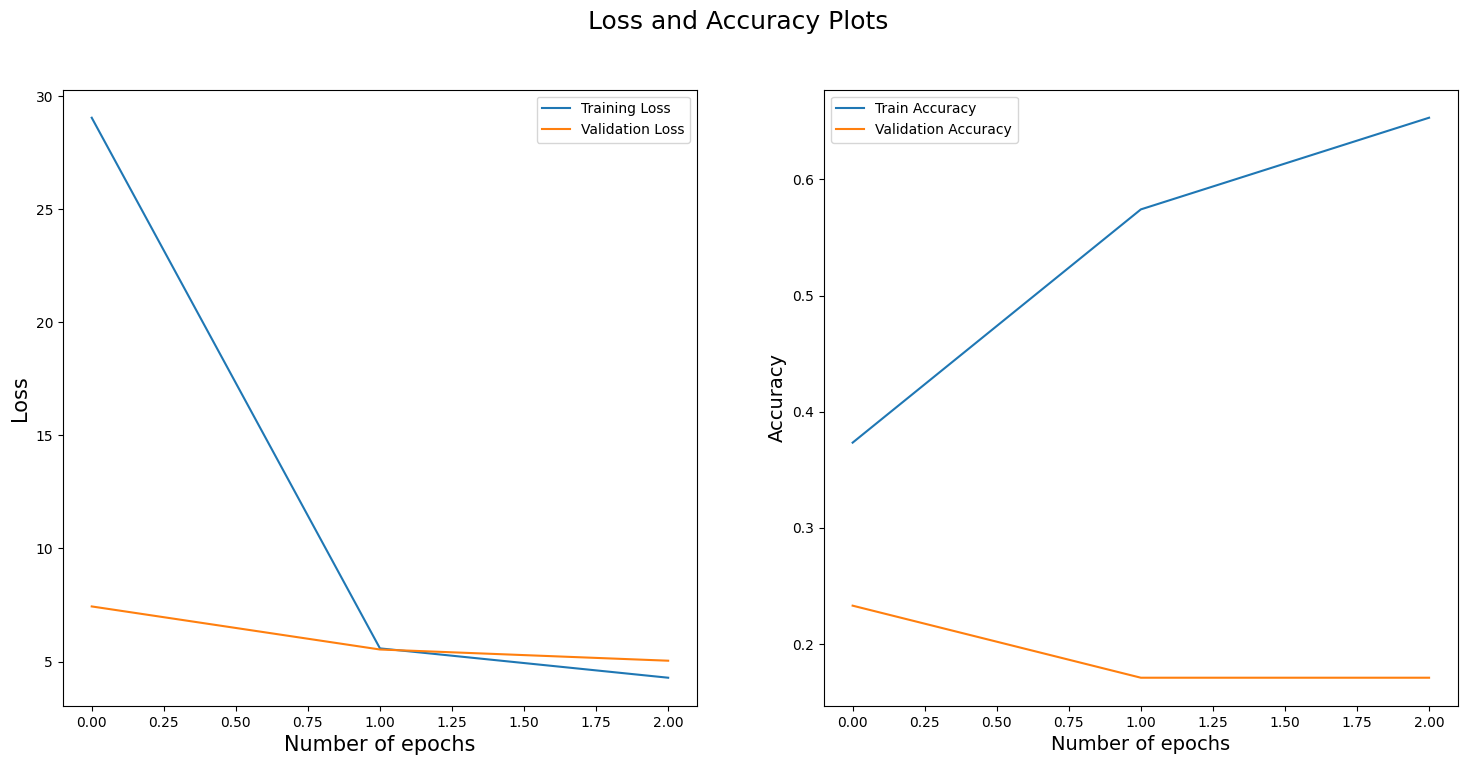

In [14]:
def show_history(history):
    plt.figure(figsize=(18,8))

    plt.suptitle('Loss and Accuracy Plots', fontsize=18)

    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.xlabel('Number of epochs', fontsize=15)
    plt.ylabel('Loss', fontsize=15)

    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.xlabel('Number of epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.show()

show_history(history)

In [12]:
training_generator = datagen.flow_from_dataframe(train, x_col='X', y_col="y", target_size=(SIZE, SIZE), interpolation='lanczos', shuffle=False) #shuffle=False
validation_generator = valid_gen.flow_from_dataframe(test, x_col='X', y_col="y", target_size=(SIZE, SIZE),interpolation='lanczos', shuffle=False) #interpolation='lanczos'

Found 4699 validated image filenames belonging to 9 classes.
Found 2014 validated image filenames belonging to 9 classes.


In [15]:


y_train = train['y']
y_train = y_train.replace(training_generator.class_indices)
y_train = keras.utils.to_categorical(y_train, num_classes=9)

<ipython-input-15-3b494a12dc4f>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_train = y_train.replace(training_generator.class_indices)


In [16]:




y_test = test['y']
y_test = y_test.replace(validation_generator.class_indices)
y_test = keras.utils.to_categorical(y_test, num_classes=9)


<ipython-input-16-0d46475d52f1>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_test = y_test.replace(validation_generator.class_indices)


In [22]:
y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [17]:
predictions = model.predict(validation_generator, )

63/63 [==============================] - 109s 2s/step


In [77]:

predictions3 = model.predict(X, )


1/1 [==============================] - 3s 3s/step


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       106
           1       0.00      0.00      0.00       225
           2       0.00      0.00      0.00       322
           3       0.00      0.00      0.00       251
           4       0.00      0.00      0.00       109
           5       0.00      0.00      0.00        95
           6       0.00      0.00      0.00       469
           7       0.17      1.00      0.29       344
           8       0.00      0.00      0.00        93

    accuracy                           0.17      2014
   macro avg       0.02      0.11      0.03      2014
weighted avg       0.03      0.17      0.05      2014



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


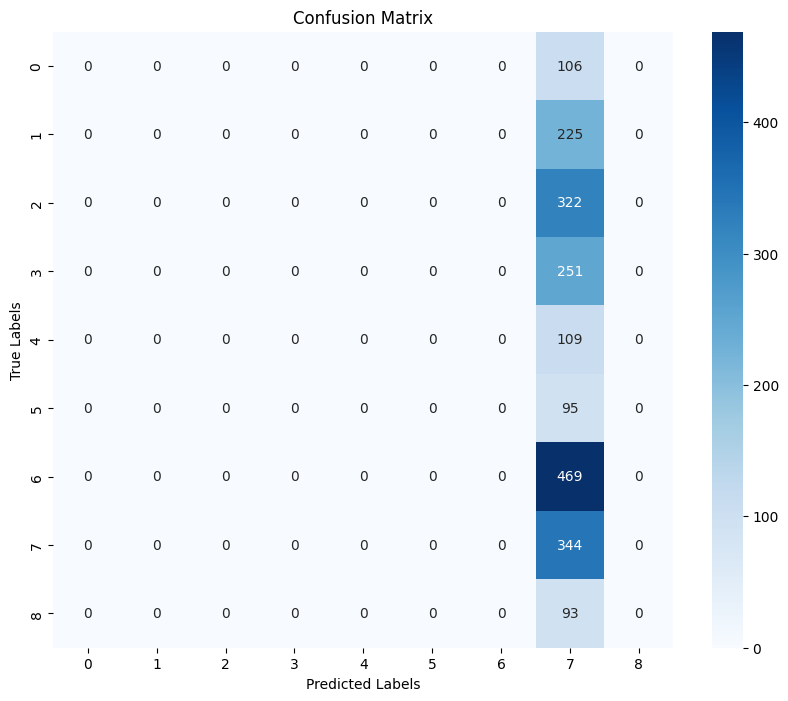

In [18]:

predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

print(classification_report(true_classes, predicted_classes))

cm = confusion_matrix(true_classes, predicted_classes)


plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



In [19]:
predictions2 = model.predict(training_generator, )

147/147 [==============================] - 275s 2s/step


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       247
           1       0.00      0.00      0.00       525
           2       0.00      0.00      0.00       751
           3       0.00      0.00      0.00       585
           4       0.00      0.00      0.00       255
           5       0.00      0.00      0.00       221
           6       0.00      0.00      0.00      1094
           7       0.17      1.00      0.29       803
           8       0.00      0.00      0.00       218

    accuracy                           0.17      4699
   macro avg       0.02      0.11      0.03      4699
weighted avg       0.03      0.17      0.05      4699



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


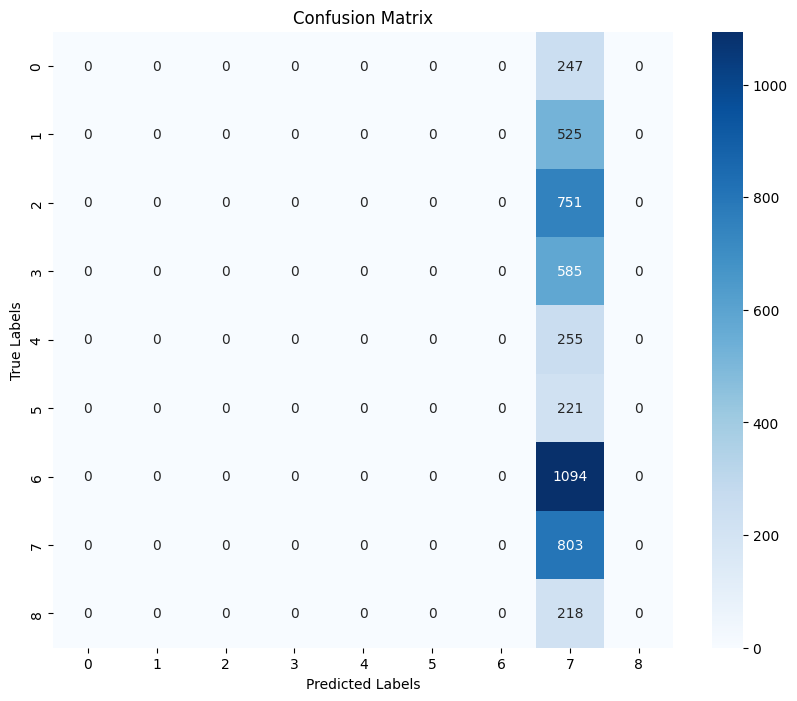

In [20]:

predicted_classes = np.argmax(predictions2, axis=1)
true_classes = np.argmax(y_train, axis=1)

print(classification_report(true_classes, predicted_classes))

cm = confusion_matrix(true_classes, predicted_classes)


plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
